# ===========================================================

# Skill Influence Relationship
# ===========================================================


# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import scipy as sp
sys.path.insert(0, '../src/')

import text_processor
import pogs_jeopardy_log_lib
import broadcast_network_extraction
import utils
from mytimer import Timer

# Parameters

In [2]:
directory = '/Users/koasato/Documents/koa/College/UCSB/2019-2020/Research/Jeopardy/'
number_of_questions_required_to_be_answered = 10

# Load Data

In [3]:
data = utils.load_it(directory + 'Teams_logs.pk')

In [4]:
len(data)

49

In [5]:
if data == None or len(data) != 49:
    with Timer():
        team = pd.read_csv(directory+"team.csv",
                           sep=',',
                           quotechar="|",
                           names=["id","sessionId","roundId", "taskId"])
        data = {}
        for i in range(0, len(team)):
            team_id = team.iloc[i]['id']
            print("Processing team", team_id, '...')
            try:
                data[team_id] = pogs_jeopardy_log_lib.TeamLogProcessor(team_id=team_id, logs_directory_path=directory)
            except pogs_jeopardy_log_lib.EventLogsNotLoadedError as e:
                print('Team {} is not found in the logs. There is nothing we can do.'.format(team_id))
                continue
            except Exception as e2:
                print('Team {} had some problems. Check.'.format(team_id))
                continue

In [6]:
len(data)

49

In [7]:
utils.save_it(data, directory+'Teams_logs.pk', verbose=True)

/Users/koasato/Documents/koa/College/UCSB/2019-2020/Research/Jeopardy/Teams_logs.pk is successfully saved.


# Load question info

In [8]:
questions = []
for i in range(data[7].game_info.num_of_questions):
    questions.append(data[7].game_info.questions[i])
print(len(questions))
print(sorted(data[7].members))

45
[17, 18, 19, 20]


# Get skill of a team

In [9]:
def get_skill_of_team(team_id, output=False):
    team_num_correct_answers = {}
    team_num_questions_answered = {}
    skill = {}
    for member_id in sorted(data[team_id].members):
        num_correct_answers = {
                      pogs_jeopardy_log_lib.Category.SCIENCE_AND_TECHNOLOGY: 0,
                      pogs_jeopardy_log_lib.Category.HISTORY_AND_MYTHOLOGY: 0,
                      pogs_jeopardy_log_lib.Category.LITERATURE_AND_MEDIA: 0}
        num_questions_answered = {
                      pogs_jeopardy_log_lib.Category.SCIENCE_AND_TECHNOLOGY: 0,
                      pogs_jeopardy_log_lib.Category.HISTORY_AND_MYTHOLOGY: 0,
                      pogs_jeopardy_log_lib.Category.LITERATURE_AND_MEDIA: 0}
        
        if (len(data[team_id].member_influences) == 0):
            print("Not including {} because they have no influence matrices for team {}".format(member_id, team_id))
            continue
        
        if (len(data[team_id].individual_answers_chosen.keys()) < number_of_questions_required_to_be_answered):
            print("Not including {} because they have less than 5 questions answered for team {}".format(member_id, team_id))
            continue
        
        #for question_id in data[team_id].individual_answers_chosen.keys():
        for question_id in range(1, len(questions) + 1):
            print ("\n", question_id) if output else None
            print('Question: ', questions[question_id - 1].question_content) if output else None
            print('Answer: ', questions[question_id - 1].answer) if output else None
            if (question_id not in data[team_id].individual_answers_chosen or 
                member_id not in data[team_id].individual_answers_chosen[question_id]):
                print('User answer: not there') if output else None
                print('Category: ', questions[question_id - 1].category) if output else None
                print('Difficulty: ', questions[question_id - 1].level) if output else None
                continue

            member_answer =  data[team_id].individual_answers_chosen[question_id][member_id]
            print("Member {}'s answer: {}".format(member_id, member_answer)) if output else None
            num_questions_answered[questions[question_id - 1].category] += 1

            if questions[question_id - 1].answer == member_answer:
                print('Correct') if output else None
                num_correct_answers[questions[question_id - 1].category] += 1
            else:
                print('Incorrect') if output else None
            print('Category: ', questions[question_id - 1].category) if output else None
            print('Difficulty: ', questions[question_id - 1].level) if output else None
        team_num_correct_answers[member_id] = num_correct_answers
        team_num_questions_answered[member_id] = num_questions_answered
              
        percentages_correct = {}
        for key in num_correct_answers.keys():
            if (num_questions_answered[key] == 0):
                percentages_correct[key] = 'No questions answered'
            else:
                percentages_correct[key] = num_correct_answers[key]/num_questions_answered[key]
        percentages_correct['all'] = sum(num_correct_answers.values())/sum(num_questions_answered.values())
        skill[member_id] = percentages_correct
    
    print ("\nNumber of correctly answered questions")if output else None
    for k in team_num_correct_answers.keys():
        print(k) if output else None
        print(team_num_correct_answers[k] ) if output else None
        
    print ("\nNumber of attempted questions")if output else None
    for k in team_num_questions_answered.keys():
        print(k) if output else None
        print(team_num_questions_answered[k]) if output else None
    print(skill) if output else None
    return skill

In [27]:
skill = get_skill_of_team(7, output=True)


 1
Question:  Which kind of waves are used to make and receive cellphone calls?
Answer:  Radio Waves
Member 17's answer: Radio Waves
Correct
Category:  Category.SCIENCE_AND_TECHNOLOGY
Difficulty:  Level.EASY

 2
Question:  Which acid is present in lemon?
Answer:  citric acid
Member 17's answer: citric acid
Correct
Category:  Category.SCIENCE_AND_TECHNOLOGY
Difficulty:  Level.EASY

 3
Question:  The intensity of Earthquakes is measured on
Answer:  Richter scale
User answer: not there
Category:  Category.SCIENCE_AND_TECHNOLOGY
Difficulty:  Level.EASY

 4
Question:  Balloons are filled with
Answer:  Helium
Member 17's answer: Helium
Correct
Category:  Category.SCIENCE_AND_TECHNOLOGY
Difficulty:  Level.EASY

 5
Question:  Along with whom did Bill Gates found Microsoft?
Answer:  Paul Allen
User answer: not there
Category:  Category.SCIENCE_AND_TECHNOLOGY
Difficulty:  Level.EASY

 6
Question:  On the verge of going bust in 1997, it was saved by a $150M investment by rival Microsoft
Answer: 

# Get skill of all the teams

In [29]:
def get_skill_of_teams():
    all_skill = {}
    for team_id in sorted(data.keys()):
        skill_for_team = get_skill_of_team(team_id)
        if len(skill_for_team.keys()) > 0:
            all_skill[team_id] = skill_for_team
    print(len(all_skill))
    return all_skill

In [30]:
def get_overall_accuracy():
    overall_accuracy = []
    for team_id in sorted(all_skill.keys()):
        for member_id in sorted(all_skill[team_id].keys()):
            overall_accuracy.append(all_skill[team_id][member_id]['all'])
    print(len(overall_accuracy)//4)
    print(len(all_skill))
    return overall_accuracy

# Get average final influence value of all members

In [13]:
def get_average_final_rating():
    average_final_rating = []

    for team_id in data.keys():
        if (len(data[team_id].individual_answers_chosen) < number_of_questions_required_to_be_answered):
            continue
        if len(data[team_id].member_influences) == 0:
            print("omitting team ", team_id)
            continue
        for member_id in sorted(data[team_id].members):
            index = data[team_id].members.index(member_id)
            total_rating = 0
            for i in range(len(data[team_id].members)):
                if i != index:
                    total_rating += data[team_id].member_influences[-1][i][index]
            average_final_rating.append(total_rating / (len(data[team_id].members ) - 1))

    print(average_final_rating[0])
    return average_final_rating

In [31]:
all_skill = get_skill_of_teams()
overall_accuracy = get_overall_accuracy()
average_final_rating = get_average_final_rating()
print(len(overall_accuracy))
print(len(average_final_rating))

Not including 106 because they have less than 5 questions answered for team 31
Not including 107 because they have less than 5 questions answered for team 31
Not including 108 because they have less than 5 questions answered for team 31
Not including 109 because they have less than 5 questions answered for team 31
Not including 130 because they have no influence matrices for team 35
Not including 131 because they have no influence matrices for team 35
Not including 132 because they have no influence matrices for team 35
Not including 133 because they have no influence matrices for team 35
Not including 243 because they have no influence matrices for team 72
Not including 244 because they have no influence matrices for team 72
Not including 245 because they have no influence matrices for team 72
Not including 246 because they have no influence matrices for team 72
Not including 247 because they have no influence matrices for team 73
Not including 248 because they have no influence matri

Text(0,0.5,'average_final_rating')

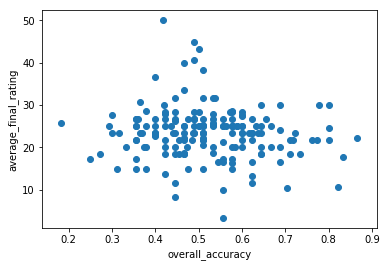

In [25]:
plt.scatter(overall_accuracy, average_final_rating)
plt.xlabel("overall_accuracy")
plt.ylabel("average_final_rating")

In [26]:
sp.stats.pearsonr(overall_accuracy, average_final_rating)

(-0.10683054054781628, 0.15346897018214223)